# Завдання 4: Регресіне моделювання

Іноді основна мета регресійного аналізу - дізнатися щось про нахил або перетин найбільш відповідної лінії регресії. Коли ми використовуємо вибірку даних для оцінки нахилу або перетину, наша оцінка схильна до випадкової помилки, як і наші оцінки середніх і медіан генеральної сукупності.

У цій практичній роботі ми будемо використовувати лінійну регресію для оцінки віку Всесвіту за зображеннями зірок, що вибухають (актуальне питання як для астрофізиків, так і для геофізиків). Наша оцінка буде використовувати вибірку зірок, що вибухнули. Ми обчислимо довірчий інтервал для кількісної оцінки похибки, спричиненої вибіркою.

Для самоконтролю використовуються тести автогрейдера (from gofer.ok import check), як і в поперідній работі. Якщо Ви їх ще не використовували, то для їх викоритання необхідно інсталювати два додаткових модуля (через CMD.exe Prompt в ANACONDA NAVIGATOR) а саме:

- **okgrade** (pip install okgrade) https://okgrade.readthedocs.io/_/downloads/en/latest/pdf/
- **gofer** (pip install git+https://github.com/grading/gradememaybe.git) https://okgrade.readthedocs.io/en/latest/install/

Якщо Ви не бажаєти їх викоритовувати, то закоментуйте відповідний рядок і не використовуйте рядки тесту (наприклад check('tests/q2_1.py'), ...). В такому разі Ви можете переглянути наявні тести у відповідній директорії

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# These lines load the tests.
from gofer.ok import check

## 1. Вік Всесвіту

### Справжня теорія Великого вибуху (Big Bang theory)
На початку 20 століття найпопулярніша космологічна теорія передбачала, що Всесвіт завжди був фіксованого розміру. Сьогодні переважає теорія Великого вибуху: наш Всесвіт спочатку був дуже маленьким (у сінгулярності) і продовжує розширюватися.

Наслідком цього є закон Хаббла, який свідчить, що розширення Всесвіту створює видимість того, що кожен небесний об'єкт, що знаходиться досить далеко від Землі (наприклад, інша галактика), віддаляється від нас із постійною швидкістю. Якщо ми екстраполюємо цей рух у минуле, на той час, коли все у Всесвіті було в "одному" місці, то цей час і буде (приблизно) початком Всесвіту (віком Всесвіту)!

Вчені використовували цей факт, поряд з вимірами поточного місця *розташування* і *швидкості руху* інших небесних об'єктів, щоб оцінити, коли виник Всесвіт.

Комірка нижче імітує Всесвіт, у якому наше Сонце є центром, а решта зірок віддаляється від нас. Кожна зірка починає рух з того самого місця, де знаходиться Сонце, а потім згодом віддаляється від нього. Різні зірки мають різні напрямки *та швидкості*; стрілки вказують напрямок і швидкість руху.

Запустіть наступну комірку, потім перемістіть повзунок, щоб побачити, як усе змінюється з часом.

In [2]:
# Just run this cell.  (The simulation is actually not
# that complicated; it just takes a lot of code to draw
# everything.  So you don't need to read this unless you
# have time and are curious about more advanced plotting.)

num_locations = 15
example_velocities = Table().with_columns(
    "x", np.random.normal(size=num_locations),
    "y", np.random.normal(size=num_locations))
start_of_time = -2

def scatter_after_time(t, start_of_time, end_of_time, velocities, center_name, other_point_name, make_title):
    max_location = 1.1*(end_of_time-start_of_time)*max(max(abs(velocities.column("x"))), max(abs(velocities.column("y"))))
    new_locations = velocities.with_columns(
            "x", (t-start_of_time)*velocities.column("x"),
            "y", (t-start_of_time)*velocities.column("y"))
    plt.scatter(make_array(0), make_array(0), label=center_name, s=100, c="yellow")
    plt.scatter(new_locations.column("x"), new_locations.column("y"), label=other_point_name)
    for i in np.arange(new_locations.num_rows):
        plt.arrow(
            new_locations.column("x").item(i),
            new_locations.column("y").item(i),
            velocities.column("x").item(i),
            velocities.column("y").item(i),
            fc='black',
            ec='black',
            head_width=0.025*max_location,
            lw=.15)
    plt.xlim(-max_location, max_location)
    plt.ylim(-max_location, max_location)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_position(make_array(0, 0, 1, 1))
    plt.legend(bbox_to_anchor=(1.6, .7))
    plt.title(make_title(t))
    plt.show()

interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=start_of_time, max=5, step=.05, value=0, msg_throttle=1),
    start_of_time=fixed(start_of_time),
    end_of_time=fixed(5),
    velocities=fixed(example_velocities),
    center_name=fixed("our sun"),
    other_point_name=fixed("other star"),
    make_title=fixed(lambda t: "The world {:01g} year{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

interactive(children=(FloatSlider(value=0.0, description='t', max=5.0, min=-2.0, step=0.05), Output()), _dom_c…

### Аналогія: водіння
Ось аналогія, щоб проілюструвати, як вчені використовують інформацію про зірки для оцінки віку Всесвіту.

Припустімо, що в якийсь момент у минулому наша друг, нехай це буде Олександр, почав їхати в машині зі стабільною швидкістю 60 кілометрів на годину на схід. Ми ж все ще стоїмо там, звідки він почав рух.

In [3]:
# Run this cell to see a picture of Olexander's locations over time.

mei_velocity = Table().with_columns("x", make_array(60), "y", make_array(0))
interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=-2, max=1, step=.05, value=0, msg_throttle=1),
    start_of_time=fixed(-2),
    end_of_time=fixed(1),
    velocities=fixed(mei_velocity),
    center_name=fixed("Us"),
    other_point_name=fixed("Olexander"),
    make_title=fixed(lambda t: "Olexander's position {:01g} hour{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, min=-2.0, step=0.05), Output()), _dom_c…

Ми хочемо знати, як довго він був за кермом, але ми забули записати час, коли він почав рух. Якщо ми дізнаємося, що він знаходиться за 120 кілометрів від нас і весь цей час їде зі швидкістю 60 кілометрів на годину, ми можемо зробити висновок, що він почав рух 2 години тому.

Один із способів, яким ми можемо обчислити це число, - це оціночна лінія (лінія регресії) для діаграми розсіювання наших позицій і швидкостей. Виявляється, *нахил* (*slope*) цієї лінії - це кількість часу, що минув. Запустіть наступну комірку, щоб побачити зображення:

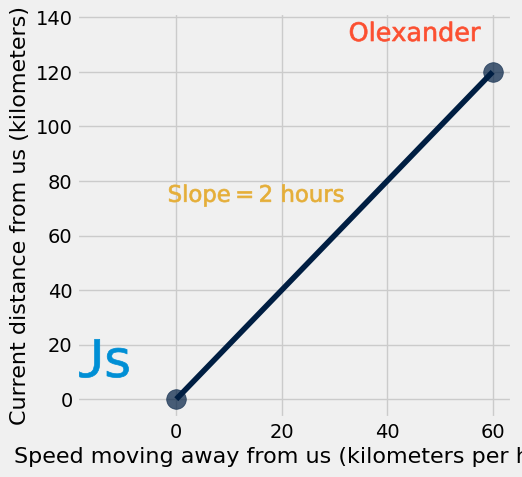

In [4]:
# Just run this cell.
small_driving_example = Table().with_columns(
        "Name",                                       make_array("Us", "Olexander"),
        "Speed moving away from us (kilometers per hour)", make_array(0,    60),
        "Current distance from us (kilometers)",           make_array(0,    120))

small_driving_example.scatter(1, 2, s=200, fit_line=True)

# Fancy magic to draw each person's name with their dot.
with_slope_indicator = small_driving_example.with_row(
    ["Slope = 2\ hours", small_driving_example.column(1).mean(), small_driving_example.column(2).mean()])
for i in range(with_slope_indicator.num_rows):
    name = with_slope_indicator.column(0).item(i)
    x = with_slope_indicator.column(1).item(i)
    y = with_slope_indicator.column(2).item(i)
    plt.scatter(make_array(x - 15), make_array(y + 15), s=1000*len(name), marker="$\mathrm{" + name + "}$")

Нахил (slope) лінії - 2 години. (Одиницями виміру є - одиниці виміру по вертикальній осі, поділені на одиниці виміру по горизонтальній осі, які дорівнюють $\frac{\texttt{кілометрів}}{\texttt{кілометрів} / \texttt{годину}}$, або `годин`.) Отже, це наша відповідь.

Уявіть, що ви не знаєте точної відстані чи швидкості Олександра, лише приблизні оцінки. Тоді, якщо ви намалюєте цю лінію, ви отримаєте трохи "погану" оцінку часу, що проїхав Олександр відтоді, як почав рух. Але якби ви виміряли відстань і швидкість сотень людей, які почали рух від Вас одночасно на різних швидкостях, і ми провели лінію регресії чарез сотні вимірів (нехай і недостатньо точних), нахил цієї лінії був би досить гарною оцінкою часу, який вони проїхали, і дійсно, навіть якщо індивідуальні вимірювання були не зовсім точними.

Набір даних `drivers.csv` містить швидкість і дистанцію від початку руху для 100 водіїв. Усі вони покинули одне й те саме стартове місце одночасно, рухаючись із фіксованою швидкістю по прямій від старту. Виміри є не точними, тому вони не відповідають точній лінії регресії. Ми створили діаграму розсіювання та провели лінію регресії через ці дані.

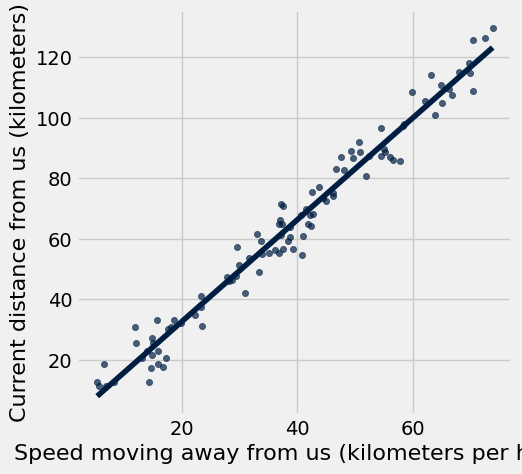

In [5]:
# Just run this cell.
Table.read_table("drivers.csv").scatter(0, 1, fit_line=True)

** <b>Завдання 1.1</b> ** <br/>
Подивившись на відповідну лінію і оцініть, як давно (у годинах) Олександр проїхів.

In [6]:
# Fill in the start time you infer from the above line.
# You can define additional functions
driving_start_time_hours = 5/3
driving_start_time_hours

1.6666666666666667

In [7]:
check('tests/q1_1.py')

### Повернемося до космології
Щоб зробити те саме для Всесвіту, нам потрібно знати відстань від Землі та швидкість від Землі для багатьох небесних об’єктів. Використовуючи фотографії, зроблені дуже точними телескопами, і фізичні обчислення, астрономи змогли оцінити обидва критерії. Виявляється, що *найближчі наднові* — зірки, які нещодавно загинули та вибухнули — є одними з найкращих джерел цих даних, оскільки їх відносно легко побачити. На цьому знімку, зробленому телескопом Hubble, зображена ціла галактика з однією надновою, яка сама по собі яскрава, як мільярди зірок, знизу ліворуч.

<img src="supernova.jpg">

Ці астрономічні дані на сьогодні надходять із [Проекту космології наднових](http://supernova.lbl.gov/union/) у Лабораторії Лоуренса Берклі. Оригінальний набір даних знаходиться [тут](http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt), із (короткою) документацією [тут](http://supernova.lbl.gov/union/descriptions.html#Magvsz). Кожен рядок у таблиці відповідає надновій зірці поблизу Землі, яку спостерігали астрономи. З фотографій, подібних до наведеної вище, астрономи зробили висновок про те, наскільки далеко кожна наднова була від Землі та як швидко вона віддалялася від Землі. Їх висновки були гарними, але не ідеальними.

Запустіть наступну комірку, щоб завантажити дані в таблицю під назвою `close_novas` і створити діаграму розсіювання. (Якщо ви віддаєте перевагу, ви також можете використати назву `close_novae`; обидві назви правильні.)

Speed (parsecs/year),Distance (million parsecs)
0.00873361,117.305
0.0153418,217.007
0.0162256,230.961
0.00528131,85.2853
0.0129474,185.051
0.0138862,212.841
0.0111837,151.728
0.0060085,82.6121
0.00838228,104.029
0.00812078,124.778


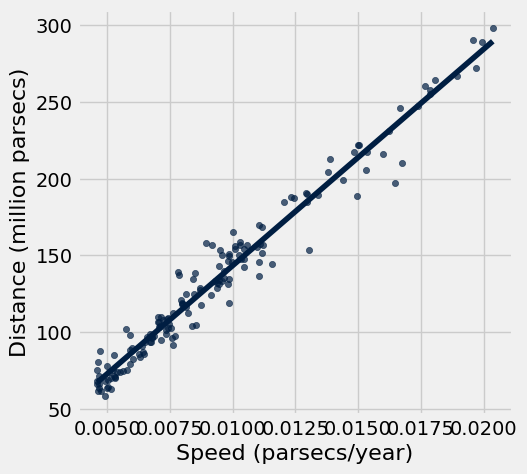

In [8]:
# Just run this cell.
close_novas = Table.read_table("close_novas.csv")
close_novae = close_novas

close_novas.scatter(0, 1, fit_line=True)
close_novas

** <b>Завдання 1.2</b> ** <br/>
Дивлячись на цю діагрму, здогадайтеся про вік Всесвіту.

**Примітка**: переконайтеся, що Ви правильно визначили одиниці вимірюванн! Якщо вам потрібно знати, що таке парсек, то це велика одиниця відстані, еквівалентна 30,86 трильйону кілометрів.

In [9]:
# Fill this in manually by examining the line above.
first_guess_universe_age_years = 250e+6 / 1.75e-2

# This just shows your guess as a nice string, in billions of years.
"{:,} billion years".format(round(first_guess_universe_age_years / 1e9, 2))

'14.29 billion years'

In [10]:
check('tests/q1_2.py')

### Підбір лінії своїми руками
`fit_line=True` це зручно, але нам потрібно мати можливість обчислити нахил (slope) як число. Згадайте, що лінія регресії підібрана методом найменших квадратів для наших даних про наднову виглядає так:
* лінія з найменшими середнім (за всіма надновими, які ми спостерігаємо) похобками, підведеними до квадрату, де похибка є

$$\text{фактична відстань наднової від Землі} - \text{висота лінії швидкості цієї наднової.}$$

** <b>Завдання 1.3</b> ** <br/>
Визначте функцію під назвою `errors`. Вона має приймати три аргументи:
1. таблиця на зразок `close_novas` (з однаковими назвами стовпців і значеннями, але не обов’язково однаковими даними)
2. нахил (slope) лінії регресії (число)
3. перетин (intercept) лінії регресії (число).

Функція повинна повернути масив похибок, допущених, коли лінія з таким нахилом і перетином використовується для прогнозування відстані за швидкостю для кожної наднової в даній таблиці. (Похибка — це фактична відстань мінус прогнозована відстань.)

In [11]:
def errors(t, slope, intercept):
    real_distance = t[1]
    pred_distance = t[0] * slope + intercept
    return real_distance - pred_distance

** <b>Завдання 1.4</b> ** <br/>
Using `errors`, compute the errors for the line with slope `16000` and intercept `0` on the `close_novas` dataset.  Name that array `example_errors`.  Then make a scatter plot of the errors. Використовуючи функцію  `errors`, обчисліть похибки для лінії регресії з нахилом (slope) `16000` і перетином (intercept) `0` у наборі даних `close_novas`. Назвіть цей масив `example_errors`. Потім побудуйте діаграму розсіювання для нев'язок.

**Підказка:** Щоб створити діаграму розсіювання нев'язок, побудуйте діаграму нев'язок для кожної наднової в наборі даних. Відкладіть фактичну швидкість на горизонтальній осі, а нев'язку – на вертикальній.

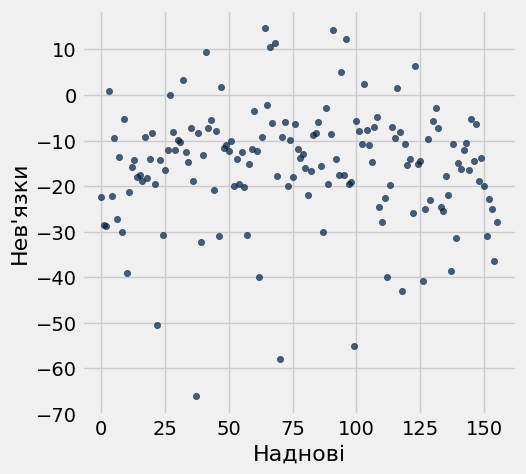

In [12]:
example_errors = errors(close_novas, 16000, 0)
Table().with_columns(
        "Нев'язки", example_errors,
        "Наднові", np.arange(0, len(example_errors))
    ).scatter(1)

In [13]:
check('tests/q1_4.py')

Ви повинні відмітити, що майже всі нев'язки є від'ємними. Це означає, що наша лінія трохи крута. Давай знайдемо кращу.

** <b>Завдання 1.5</b> ** <br/>
Визначте функцію під назвою `fit_line`. Вона повинна прийняти таблицю на кшталт `close_novas` (з тими ж назвами стовпців і значеннями) як аргумент. Вона повинна повернути масив, що містить нахил (slope) (як елемент 0) і перетин (intercept) (як елемент 1) лінії регресії за методом найменших квадратів, яка прогнозує відстань за швидкостю для цієї таблиці.

**Підказка:** Якщо ви ще не намагалися використовувати функцію [`minimize` function](http://data8.org/datascience/util.html#datascience.util.minimize), зараз саме час попрактикуватися. Ось [приклад із підручника](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares).

In [14]:
def fit_line(tbl):
    # Your code may need more than 1 line below here.
    # Rather than using the regression line formulas, try
    # calling minimize on the mean squared error.
    ...
    coefs = minimize(lambda a, b: np.mean(errors(tbl, a, b)**2))
    return coefs
    
# Here is an example call to your function.  To test your function,
# figure out the right slope and intercept by hand.
example_table = Table().with_columns(
    "Speed (parsecs/year)", make_array(0, 1),
    "Distance (million parsecs)", make_array(1, 3))
fit_line(example_table)

array([ 2.,  1.])

In [15]:
check('tests/q1_5.py')

** <b>Завдання 1.6</b> ** <br/>
Використовуйте визначану функцію, щоб підібрати лінію регресії до `close_novas`.

Потім визначте змінну `new_errors` рівною нев'язкам, які ми отримуємо, викликаючи функцію `errors` з параметрами для нашої нової лінії регресії. У комірці нижче буде зображено відповідну дяаграму нев'язок із лінією регресії, яка найкраще оцінює дані.

Переконайтеся, що діаграма розсіювання нев'язок має сенс (Підказка: які критерії повинна мати найкраще підібрана лінія регресії для діаграми нев'язок?)

'Slope: 14094.5 (corresponding to an estimated age of 14.0945 billion years)'

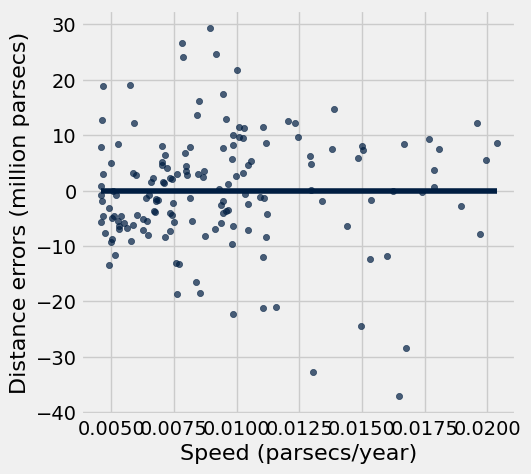

In [16]:
best_line = fit_line(close_novas)
best_line_slope = best_line[0]
best_line_intercept = best_line[1]

new_errors = errors(close_novas, best_line_slope, best_line_intercept)

# This code displays the residual plot, given your values for the best_line_slope and best_line_intercept
Table().with_columns("Speed (parsecs/year)", 
                    close_novas.column("Speed (parsecs/year)"), 
                    "Distance errors (million parsecs)", 
                    new_errors
                   ).scatter(0, 1, fit_line=True)

# This just shows your answer as a nice string, in billions of years.
"Slope: {:g} (corresponding to an estimated age of {:,} billion years)".format(best_line_slope, round(best_line_slope/1000, 4))

Цей нахил (slope) (помножений на 1 мільйон) є приблизною оцінкою віку Всесвіту. Найкраща поточна оцінка віку Всесвіту (з використанням трохи складніших методів) становить 13,799 мільярда років. Ми наблизилися до такої оцінки? 

Однією з причин, чому наша відповідь може бути трохи неточною, є те, що ми використовуємо вибірку лише деяких наднових зірок у Всесвіті. Наша вибірка не зовсім випадкова, оскільки астрономи, ймовірно, вибрали наднові, які було найлегше виміряти (або використали інші невипадкові критерії). Але припустімо, що отриманий результат нас влаштовує. Як ми можемо отримати довірчий інтервал для віку Всесвіту?

** <b>Завдання 1.7</b> ** <br/>
Настав час пезапустити вибірку багато разів (resampling), щоб ми могли кількісно визначити варіабельність нашої оцінки! Змоделюємо 1000 повторних вибірок (resampling) із `close_novas`. Для кожної повторної вибірки обчисліть нахил (slope) лінії регресії за методом найменших квадратів і помножте його на 1 мільйон, щоб обчислити оцінку віку Всесвіту. Зберігайте ці віки в масиві під назвою `bootstrap_ages`, а потім використовуйте їх для обчислення 95% довірчого інтервалу для віку Всесвіту.

**Примітка.** Це може зайняти до хвилини, а при повторенні ще більше.

95% confidence interval for the age of the universe: [13.6983, 14.4598] billion years


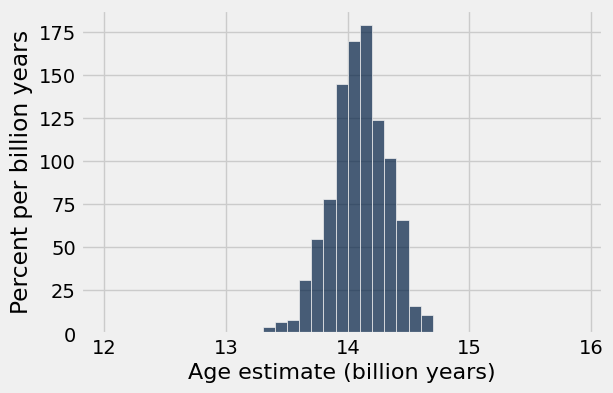

In [17]:
bootstrap_ages = make_array()
for i in np.arange(1000):
    bootstrap_ages = np.append(bootstrap_ages, fit_line(close_novas.sample())[0] * 1e+6)
bootstrap_ages.sort()
    
lower_end = bootstrap_ages[round(len(bootstrap_ages)*.05)]
upper_end = bootstrap_ages[round(len(bootstrap_ages)*.95)]
Table().with_column("Age estimate", bootstrap_ages*1e-9).hist(bins=np.arange(12, 16, .1), unit="billion years")
print("95% confidence interval for the age of the universe: [{:g}, {:g}] billion years".format(lower_end*1e-9, upper_end*1e-9))

In [18]:
check('tests/q1_7.py')

 Ми це зробили, майже як астрофізики чи геофізики! Ви можете порівняти свій результат із [результатами проекту Planck 2015](https://arxiv.org/pdf/1502.01589.pdf), який оцінив вік Всесвіту в 13,799±0,021 мільярдів років.

## Контроль

Ви закінчили з даною частиною практичної роботи! Аби перевірити, що всі завдання виконані вірно, виконайте наступні дії...
- **ВАЖЛИВО** Перш ніж щось робити, виберіть, **Save and Checkpoint** з меню `File`. Будь ласка, зробіть це спочатку, перш ніж запускати клітинку нижче,
- **запустіть усі тести та перевірте, чи всі вони пройшли успішно** (у наступній клітинці є перевірка для цього), 
- **Перегляньте notebook востаннє, перевірятися буде остаточний стан вашого notebook. Якщо ви вносили будь-які зміни, збережіть і запустіть всі рядки ще раз** Якщо ви вносили будь-які зміни, запустіть поллідовно всі рядки ще раз і збережіть **Save and Checkpoint** повторно.

95% confidence interval for the age of the universe: [13.7125, 14.4219] billion years
['tests/q1_1.py', 'tests/q1_2.py', 'tests/q1_4.py', 'tests/q1_5.py', 'tests/q1_7.py']
Question 1:


Question 2:


Question 3:


Question 4:


Question 5:


Question 6:


Question 7:


Question 8:


Question 9:


Question 10:


1.0

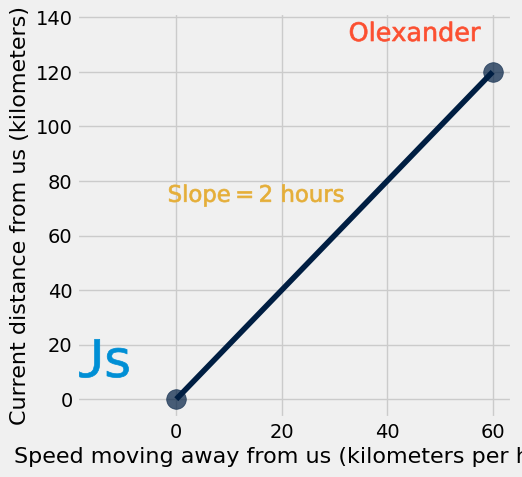

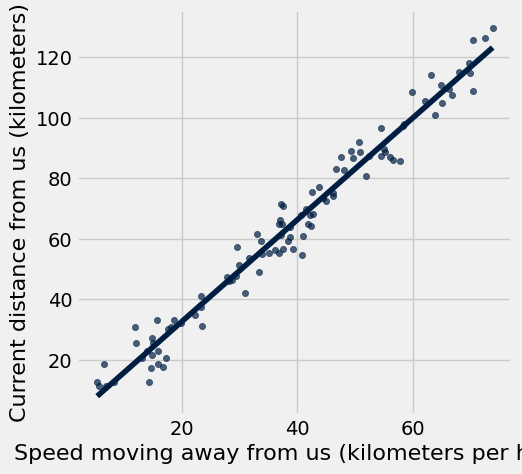

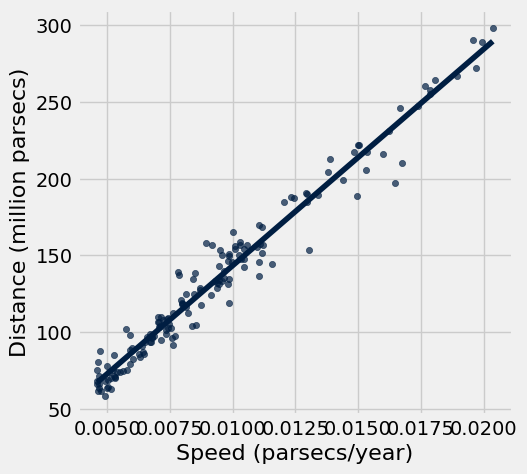

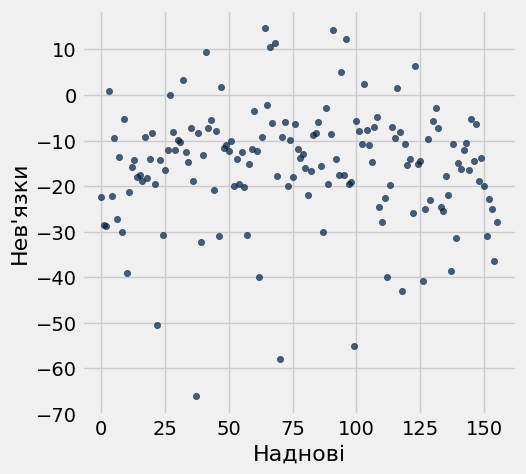

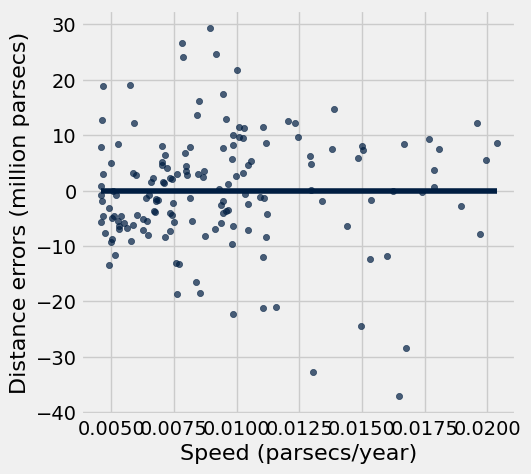

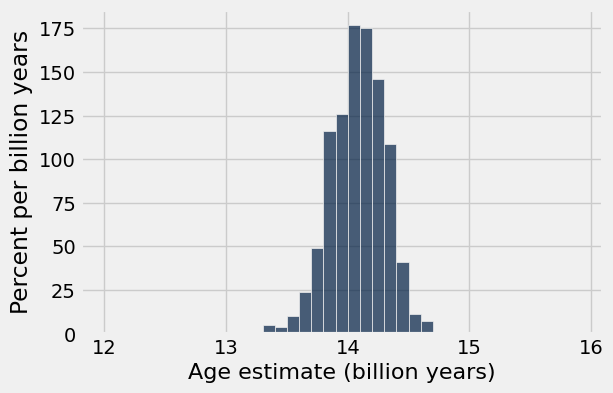

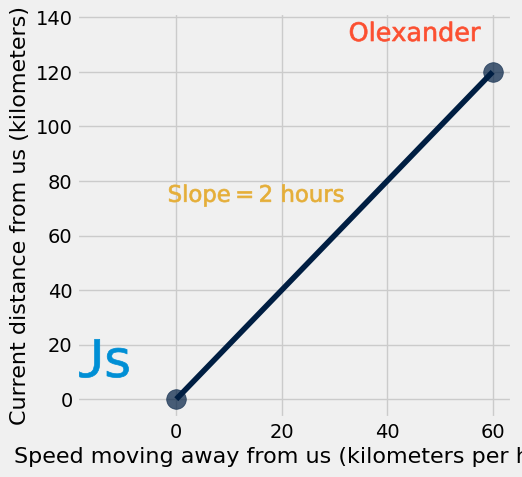

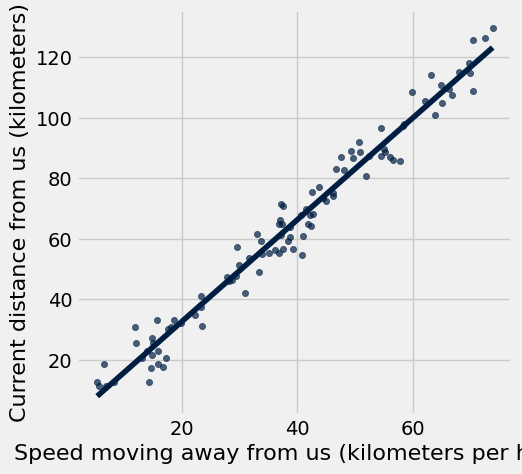

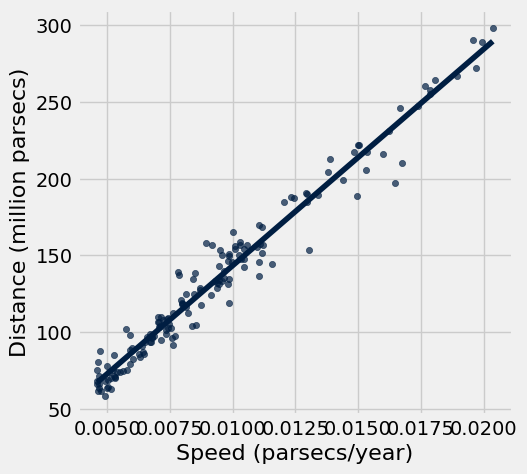

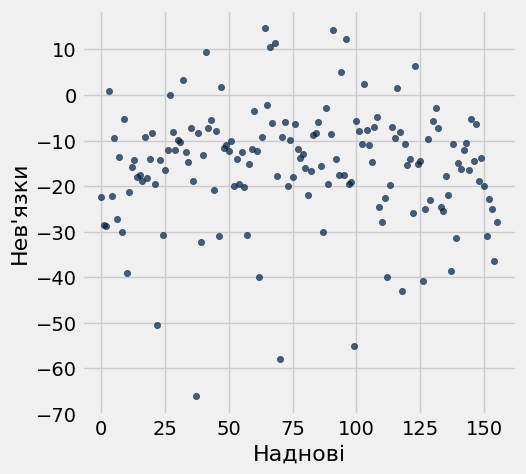

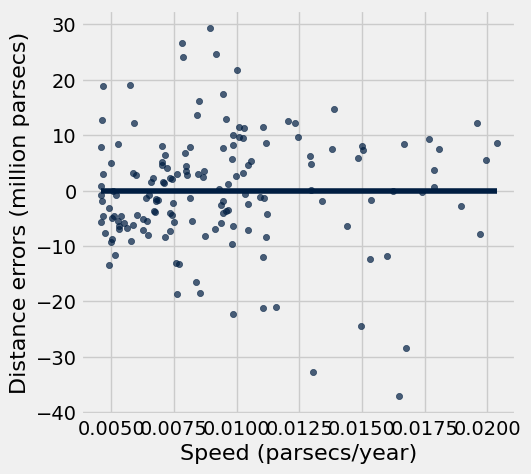

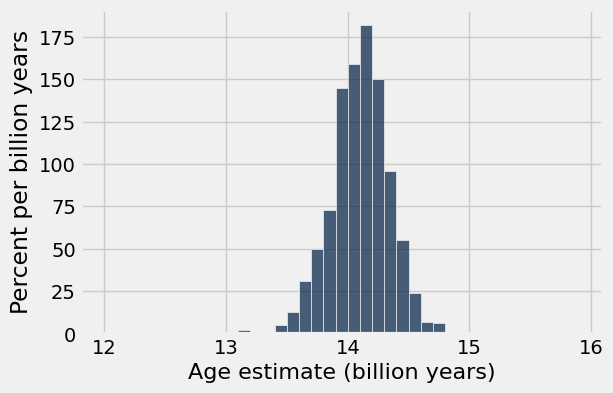

In [19]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from gofer.ok import grade_notebook
if not globals().get('__GOFER_GRADER__', False):
    display(grade_notebook('pr4_5.ipynb', sorted(glob.glob('tests/q*.py'))))